<a href="https://colab.research.google.com/github/meysamvarasteh92/meysamvarasteh/blob/main/adults_CF_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sum of score is created on ground truth, so we use ground truth information as well and its becoming like predictive parity not statiscial parity

Negative effort is there, because previously we were generating counterfactuals based on ground truth, and some of the samples initially would have 1 prediction, upon counterfactual generation, they obtain negative effort to change prediction to 0

Should we calculate Effort for all of the dataset, or for 0 ground truths, or for 0 predictions?
Should we change score and base it on prediction rather than ground truth?

Remove sum of score from model training

Should we change Majority male to base it on counterfactual? Currently majority male does not make counterfactual generation easier for men
and does not make it harder for females too, so males and females probably would have similar efforts...

Maybe we should create a model, that, based on Qualification e.g. predicts 0 or 1 for males and females. But for females, it requires more qualification
Or maybe we can create a Logistic regression, or any model, and before fitting the model, we worsen 2 features of the men, keeping the prediction constant?

Show relation of accuracy and effort?

# Import libraries

In [ ]:
!pip install dice-ml
import dice_ml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display_html
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 213 kB 2.1 MB/s 


# Data

## Preprocessing

In [ ]:
features_unique={'age': 'continuous',
'workclass': ['Private', 'Self-emp-not-inc', 'Self-emp-inc', 'Federal-gov', 'Local-gov', 'State-gov', 'Without-pay', 'Never-worked'],
'fnlwgt': 'continuous', #weight for how many people belong to that class in the individual states
'education': ['Bachelors', 'Some-college', '11th', 'HS-grad', 'Prof-school', 'Assoc-acdm', 'Assoc-voc', '9th', '7th-8th', '12th', 'Masters', '1st-4th', '10th', 'Doctorate', '5th-6th', 'Preschool'],
'education-num': 'continuous',
'marital-status': ['Married-civ-spouse', 'Divorced', 'Never-married', 'Separated', 'Widowed', 'Married-spouse-absent', 'Married-AF-spouse'],
'occupation': ['Tech-support', 'Craft-repair', 'Other-service', 'Sales', 'Exec-managerial', 'Prof-specialty', 'Handlers-cleaners', 'Machine-op-inspct', 'Adm-clerical', 'Farming-fishing', 'Transport-moving', 'Priv-house-serv', 'Protective-serv', 'Armed-Forces'],
'relationship': ['Wife', 'Own-child', 'Husband', 'Not-in-family', 'Other-relative', 'Unmarried'],
'race': ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black'],
'sex': ['Female', 'Male'],
'capital-gain': 'continuous',
'capital-loss': 'continuous',
'hours_per_week': 'continuous',
'native_country': ['United-States', 'Cambodia', 'England', 'Puerto-Rico', 'Canada', 'Germany', 'Outlying-US(Guam-USVI-etc)', 'India', 'Japan', 'Greece', 'South', 'China', 'Cuba', 'Iran', 'Honduras', 'Philippines', 'Italy', 'Poland', 'Jamaica', 'Vietnam', 'Mexico', 'Portugal', 'Ireland', 'France', 'Dominican-Republic', 'Laos', 'Ecuador', 'Taiwan', 'Haiti', 'Columbia', 'Hungary', 'Guatemala', 'Nicaragua', 'Scotland', 'Thailand', 'Yugoslavia', 'El-Salvador', 'Trinadad&Tobago', 'Peru', 'Hong', 'Holand-Netherlands'],
'result': ['>50K', '<=50K']}
features_categorical=[] #initialize empty categorical feature values
features_numerical=[] #initialize empty numerical feature values
for key in features_unique:
  if features_unique[key] != 'continuous':
    features_categorical.append(key)
  elif key != 'education-num' and key != 'fnlwgt':
    features_numerical.append(key)
  
features_categorical[:-1]
features_categorical_s=['sex','race','native_country']  #Sensitive features
#features_categorical_s=['native-country']  #Sensitive features

features_categorical_ns=list(set(features_categorical[:-1])-set(features_categorical_s))   #nonsensitive features

In [ ]:
adults_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',sep=',',header=None)

adults_df.columns = list(features_unique.keys())
#display(adults_df)

adults_df=adults_df.drop(['fnlwgt','education-num'],axis=1) #fnlwgt is useless,

for feature in features_categorical:
  adults_df.replace([' '+string for string in features_unique[feature]],features_unique[feature],inplace=True)

adults_df.loc[adults_df.result.str.contains("<=50K")==True,'result']= False
adults_df.loc[adults_df.result.str.contains(">50K")==True,'result']= True
adults_df.loc[(adults_df.relationship == 'Husband') | (adults_df.relationship == 'Wife'),'relationship'] = ' Married'
adults_df=adults_df.drop(adults_df.loc[adults_df.native_country=="Holand-Netherlands"].index.values)


def agebrackets(age):
  if age<24:
    age_range = '18-24'
  elif age<40:
    age_range = '25-40'
  elif age<60:
    age_range = '41-60'
  else:
    age_range = '>60'
  return age_range
adults_df.age = adults_df.age.apply(agebrackets)

adults_df_trial=adults_df.replace(to_replace=' ?', value=np.nan,inplace=True)
adults_df_trial=adults_df.dropna()
adults_df=adults_df.dropna()

In [ ]:
def hours_per_week_brackets(hours):
  if hours<20:
    hours_range = '0-20'
  elif hours<30:
    hours_range = '21-30'
  elif hours<40:
    hours_range = '31-40'
  elif hours<50:
    hours_range = '41-50'
  else:
    hours_range = '>50'
  return hours_range

adults_df.hours_per_week = adults_df.hours_per_week.apply(hours_per_week_brackets)

In [ ]:
features_categorical_ns.append('hours_per_week')

In [ ]:
effort_score = {} #education, marital status, workclass, occupation, relationship
dict_edu = {}
def effort_dict(adults_df,col):
  val_50K=adults_df[adults_df.result==1].groupby(col).result.describe()['count'].rename('o', inplace=True).apply(int)
  #print("val_50k:", val_50K)
  val_tot=adults_df.groupby(col).result.describe()['count'].rename('o', inplace=True).apply(int)
  #print("val_tot:",val_tot)
  ratio = (val_50K/val_tot).sort_values(ascending=False)
  #effort_wc=np.round(max_score*ratio/ratio[0],2)
  return ratio


effort_score ={effort_col : effort_dict(adults_df,effort_col) for effort_col in features_categorical_ns}
#display(effort_score)


best = 0
for effort_col in features_categorical_ns:
  best = max(best,effort_score[effort_col][0])
  #print(effort_score[effort_col][0])
  #print('best:',best)

for effort_col in features_categorical_ns:
  effort_score[effort_col] = effort_score[effort_col]/best*10
  #print('effort_score:',effort_score )
#this step is removed because it is methodologically inconsistent with how scores are otherwise calculated
#for edu_num,edu in zip (adults_df['education'].unique(),adults_df['education-num'].unique()):
#print(f'{edu_num}\t{edu}')
#dict_edu[edu] = edu_num
#effort_score['education'] = dict_edu

score_dataframe={}
df_styler={}
for col in features_categorical_ns:
  score_dataframe[col]=pd.DataFrame.from_dict(effort_score[col])
  score_dataframe[col].columns=['']
  #print('score_dataframe',score_dataframe['marital-status'])
  df_styler[col] = score_dataframe[col].style.set_table_attributes("style='display:inline'").set_caption(col)
display_html(df_styler['education']._repr_html_()+df_styler['occupation']._repr_html_()+df_styler['workclass']._repr_html_()+df_styler['marital-status']._repr_html_()+df_styler['relationship']._repr_html_()+df_styler['hours_per_week']._repr_html_(),raw=True)

,
education,
Prof-school,10.000000
Doctorate,9.967816
Masters,7.532313
Bachelors,5.626799
Assoc-voc,3.513631
Assoc-acdm,3.390414
Some-college,2.671150
HS-grad,2.193755
12th,1.026904


## Sum of scores

In [ ]:
'''
tmp = pd.Series([0 for _ in range(len(adults_df))], index = adults_df.index)
for f in features_categorical_ns:
  tmp = tmp.add(adults_df[f].apply(lambda x: float(score_dataframe[f].loc[x])), fill_value=0)
adults_df['Sum_of_Score']=tmp
'''

In [ ]:
'''
def Sum_Of_Score(score):
   if score<10:
    score_range = '0-10'
   elif score<15:
    score_range = '11-15'
   elif score<20:
    score_range = '16-20'
   elif score<25:
    score_range = '21-25'
   elif score<30:
    score_range = '26-30'
   else:
    score_range = '>30'
   return score_range
adults_df['Sum_of_Score_g'] = adults_df.Sum_of_Score.apply(Sum_Of_Score)

display(adults_df)
'''

# Model

## Baseline Models (Random and Majority Classifier)

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
import random

class RandomClassifier(BaseEstimator, ClassifierMixin):
    np.random.seed(0)

    def __init__(self):
        pass

    def fit(self, X, y=None):
        pass
    
    def predict(self, X, y=None):
        return np.random.randint(2, size=X.shape[0])
    
    def predict_proba(self, X, y=None):
        out = np.random.randint(2, size=X.shape[0])
        proba = [[[1, 0], [0, 1]][i] for i in out]
        return np.array(proba)
        
        
r = RandomClassifier()
r.fit(np.array([1,2,3,4,5]), np.array([0, 0, 1, 1, 1]))
print(r.predict(np.array([1, 2, 3, 4, 5])))


class MajorityClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, majority_feature='sex', majority_value='male', qual = False):
        self.majority_feature = majority_feature
        self.majority_value = majority_value
        self.targets = [0, 1]
        self.qual = qual

    def fit(self, X, y=None):
        pass
    
    def qual_weight(self, qual_v, base):
        
        return int(qual_v < base), int(qual_v >= base)
    
    def get_qualification(self, X):
        tmp = pd.Series([0 for _ in range(len(X))], index = X.index)
        for f in features_categorical_ns:
          tmp = tmp.add(X[f].apply(lambda x: float(score_dataframe[f].loc[x])), fill_value=0)
        return tmp
    
    def predict(self, X, y=None):
        
        # Measure qualification again
        X.loc[:, 'Sum_of_Score'] = self.get_qualification(X) 
        
        if self.qual:
            predict = X[[self.majority_feature]].apply(lambda x: self.qual_weight(X['Sum_of_Score'][x.name], 15) if x[0]==self.majority_value else list(self.qual_weight(X['Sum_of_Score'][x.name], 20)), axis = 1)
            predict = predict.apply(lambda x: np.argmax(x))
        else:
            predict = X[self.majority_feature].apply(lambda x: random.choices(self.targets, weights=(20, 80), k=1)[0] if x==self.majority_value else random.choices(self.targets, weights=(80, 20), k=1)[0])
        return predict.to_numpy()
    
    def predict_proba(self, X, y=None):
        
        # Measure qualification again
        X.loc[:, 'Sum_of_Score'] = self.get_qualification(X) 
        
        if self.qual:
            proba = X[[self.majority_feature]].apply(lambda x: list(self.qual_weight(X['Sum_of_Score'][x.name], 15)) if x[0]==self.majority_value else list(self.qual_weight(X['Sum_of_Score'][x.name], 20)), axis = 1)
            proba = list(map(list, proba))
        else:
            predict = X[self.majority_feature].apply(lambda x: random.choices(self.targets, weights=(20, 80), k=1)[0] if x==self.majority_value else random.choices(self.targets, weights=(80, 20), k=1)[0])
            proba = [[[1, 0], [0, 1]][i] for i in predict]
        return np.array(proba)
        

#r = MajorityClassifier(majority_feature='Sex', majority_value='Male')
#r.fit(pd.DataFrame({'Sex': ['Male', 'Male', 'Male', 'Male', 'Male', 'Male', 'Male']}), np.array([0, 0, 1, 1, 1, 1, 1]))
#print(r.predict(pd.DataFrame({'Sex': ['Male', 'Male', 'Male', 'Male', 'Male', 'Male', 'Male']})))


[0 1 1 0 1]


## Save Datasets

In [ ]:
'''
#target = adults_df.result
#train_dataset, test_dataset, y_train, y_test = sklearn.model_selection.train_test_split(adults_df,target,test_size=0.2,random_state=0,stratify=target)
All_Datasets={'train_dataset':train_dataset,'test_dataset':test_dataset,'y_train':y_train,'y_test':y_test}
path='/content/drive/My Drive/DATASET/All_Datasets.pkl'
with open(path, 'wb') as f:
    pickle.dump(All_Datasets, f)
'''

## Load Datasets

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/My Drive/DATASET/All_Datasets.pkl'
with open(path, 'rb') as f:
    All_Datasets=pickle.load(f)

Mounted at /content/drive


## Train models

In [ ]:
# Train test split

#target = adults_df.result
train_dataset, test_dataset, y_train, y_test = All_Datasets['train_dataset'], All_Datasets['test_dataset'], All_Datasets['y_train'], All_Datasets['y_test']
y_train = train_dataset['result'].reset_index(drop=True) 
x_train = train_dataset.drop(['result'], axis=1)
y_test = test_dataset['result'].reset_index(drop=True) 
x_test = test_dataset.drop(['result'], axis=1)
x_test = x_test.reset_index(drop=True)

In [ ]:
'''
algnames = ['Random Forest',
            'Decision Tree',
            'K-Nearest Neighbor',
            'Neural Net',
            'SVM',
            'Adaboost',
            'Random', 
            'Majority Male', 
            'Majority White']

algos = [RandomForestClassifier(n_jobs=2),
         DecisionTreeClassifier(),
         KNeighborsClassifier(),
         MLPClassifier(alpha=1, max_iter=1000),
         svm.SVC(probability=True),
         AdaBoostClassifier(),
         RandomClassifier(), 
         MajorityClassifier(majority_feature='sex', majority_value='Male', qual = True), 
         MajorityClassifier(majority_feature='race', majority_value='White', qual = True)
]
'''
algnames=['Majority Male', 
            'Majority White']
algos=[MajorityClassifier(majority_feature='sex', majority_value='Male', qual = True), 
         MajorityClassifier(majority_feature='race', majority_value='White', qual = True)    ]        

In [ ]:
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
transformations = ColumnTransformer(transformers=[('cat', categorical_transformer, features_categorical[:-1])])

def GeneratePipeline(classifier, name, transformations):
    
  print(name)
  if name in ['Random', 'Majority Male', 'Majority White']:
    clf = Pipeline(steps=[('classifier', classifier)])
    
  else:
      clf = Pipeline(steps=[('preprocessor', transformations),
                      ('classifier', classifier)])
  return clf

def TrainModels(x,y,clf):
  model=clf.fit(x, y.astype('int'))
  dice_model = dice_ml.Model(model=model, backend="sklearn")
  return model,dice_model

clf_dict = {}
model = {}
dice_model = {}

for classifier,name in zip(algos,algnames):
  clf_dict[name] = GeneratePipeline(classifier, name, transformations)
  model[name],dice_model[name] = TrainModels(x_train,y_train,clf_dict[name])

Majority Male
Majority White


In [ ]:
x_test[x_test.sex=="Female"].Sum_of_Score.mean()

15.664145010537107

## Dice

In [ ]:
d = dice_ml.Data(dataframe=train_dataset, continuous_features=['capital-loss', 'capital-gain'], outcome_name='result')
exp = {} #dictionary containing the models to generate the counterfactuals
y_out = {}
for name in algnames:
  exp[name] = dice_ml.Dice(d, dice_model[name])
  y_out[name] = pd.Series(clf_dict[name].predict(x_test)).apply(int).sort_index()

## Get All negative predictions for each algo





In [ ]:
negative_test_x = {name : pd.DataFrame() for name in algnames}
negative_test_y = {name : pd.Series() for name in algnames}

for name in algnames:
    negative_test_x[name] = x_test[y_out[name].apply(int) == 0]
    negative_test_y[name] = y_test[y_out[name].apply(int) == 0]
    print(name, len(negative_test_y[name]))

Majority Male 2882
Majority White 2468


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(train_dataset.result.unique())
print(x)
# Define bar width. We'll use this to offset the second bar.
#bar_width == 0.4

# Note we add the `width` parameter now which sets the width of each bar.
b1 = ax.bar(x, train_dataset.loc[train_dataset['sex'] == 'Male', 'count'],
            width=bar_width)
# Same thing, but offset the x by the width of the bar.
b2 = ax.bar(x + bar_width, train_dataset.loc[train_dataset['sex'] == 'Female', 'count'],
            width=bar_width)

SyntaxError: ignored

In [ ]:
for name in algnames:
  for sex in ["Male","Female"]:
      samp=negative_test_x[name][negative_test_x[name].sex==sex].Sum_of_Score.mean()
      print(name,sex,samp)

Majority Male Male 11.515905983285597
Majority Male Female 15.151811245748732
Majority White Male 13.709122146549868
Majority White Female 12.145418172939209


# Fairness Baselines

## Accuracy and statistial parity

At the end, we have some numbers, we can get correlation of these numbers with the KL divergence and see their relationship

We will show how our method is related to statistical parity 

In [ ]:
for name in algnames:
  acc = sklearn.metrics.accuracy_score(y_test.apply(int), y_out[name].apply(int))
  print(f'The accuracy for {name} is {acc*100:.1f}%')

The accuracy for Majority Male is 66.6%
The accuracy for Majority White is 61.6%


In [ ]:
sexes = ['Male', 'Female']
races = ['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other']

sp_alg = {'Random Forest':        {'Sex': {'Male':0, 'Female':0}, 'Race': {'White':0, 'Black':0, 'Asian-Pac-Islander':0, 'Amer-Indian-Eskimo':0, 'Other':0}},
            'Decision Tree':      {'Sex': {'Male':0, 'Female':0}, 'Race': {'White':0, 'Black':0, 'Asian-Pac-Islander':0, 'Amer-Indian-Eskimo':0, 'Other':0}},
            'K-Nearest Neighbor': {'Sex': {'Male':0, 'Female':0}, 'Race': {'White':0, 'Black':0, 'Asian-Pac-Islander':0, 'Amer-Indian-Eskimo':0, 'Other':0}},
            'Neural Net':         {'Sex': {'Male':0, 'Female':0}, 'Race': {'White':0, 'Black':0, 'Asian-Pac-Islander':0, 'Amer-Indian-Eskimo':0, 'Other':0}},
            'SVM':                {'Sex': {'Male':0, 'Female':0}, 'Race': {'White':0, 'Black':0, 'Asian-Pac-Islander':0, 'Amer-Indian-Eskimo':0, 'Other':0}},
            'Adaboost':           {'Sex': {'Male':0, 'Female':0}, 'Race': {'White':0, 'Black':0, 'Asian-Pac-Islander':0, 'Amer-Indian-Eskimo':0, 'Other':0}},
            'Random':             {'Sex': {'Male':0, 'Female':0}, 'Race': {'White':0, 'Black':0, 'Asian-Pac-Islander':0, 'Amer-Indian-Eskimo':0, 'Other':0}},
            'Majority Male':      {'Sex': {'Male':0, 'Female':0}, 'Race': {'White':0, 'Black':0, 'Asian-Pac-Islander':0, 'Amer-Indian-Eskimo':0, 'Other':0}},
            'Majority White':     {'Sex': {'Male':0, 'Female':0}, 'Race': {'White':0, 'Black':0, 'Asian-Pac-Islander':0, 'Amer-Indian-Eskimo':0, 'Other':0}}
         }

# SEX STATISTICAL PARITY
for sex in sexes:  
    
    tmp_test_x = x_test[x_test['sex']==sex]
    tmp_test_y = y_test[x_test['sex']==sex]
    
    for name in algnames:
      prediction = model[name].predict(tmp_test_x) # Prediction for each sensitive group
      tn, fp, fn, tp = confusion_matrix(tmp_test_y.astype(int), prediction.astype(int)).ravel()
      sp_alg[name]['Sex'][sex] = (tp+fp)/(tp+fp+tn+fn)
    
# RACE STATISTICAL PARITY    
for race in races:
    
    tmp_test_x = x_test[x_test['race']==race]
    tmp_test_y = y_test[x_test['race']==race]
    
    for name in algnames:
      prediction = model[name].predict(tmp_test_x) # Prediction for each sensitive group
      tn, fp, fn, tp = confusion_matrix(tmp_test_y.astype(int), prediction.astype(int)).ravel()
      sp_alg[name]['Race'][race] = (tp+fp)/(tp+fp+tn+fn)
        
#sp_alg

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [ ]:
plt.figure(figsize=(20, 1))
for idx, name in enumerate(algnames):
    plt.subplot(1, 9, idx+1)
    plt.title(name)
    plt.barh(list(sp_alg[name]['Sex'].keys()), list(sp_alg[name]['Sex'].values()))
    if idx != 0:
        plt.yticks([])
    plt.xlim([0, 1])

In [ ]:
plt.figure(figsize=(20, 3))
for idx, name in enumerate(algnames):
    plt.subplot(1, 9, idx+1)
    plt.title(name)
    plt.barh(list(sp_alg[name]['Race'].keys()), list(sp_alg[name]['Race'].values()))
    if idx != 0:
        plt.yticks([])
    plt.xlim([0, 1])

#### Conditional statistical parity

In [ ]:
def CSP(sum_of_score = ''):

    sexes = ['Male', 'Female']
    races = ['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other']

    sp_alg = {'Random Forest':        {'Sex': {'Male':0, 'Female':0}, 'Race': {'White':0, 'Black':0, 'Asian-Pac-Islander':0, 'Amer-Indian-Eskimo':0, 'Other':0}},
                'Decision Tree':      {'Sex': {'Male':0, 'Female':0}, 'Race': {'White':0, 'Black':0, 'Asian-Pac-Islander':0, 'Amer-Indian-Eskimo':0, 'Other':0}},
                'K-Nearest Neighbor': {'Sex': {'Male':0, 'Female':0}, 'Race': {'White':0, 'Black':0, 'Asian-Pac-Islander':0, 'Amer-Indian-Eskimo':0, 'Other':0}},
                'Neural Net':         {'Sex': {'Male':0, 'Female':0}, 'Race': {'White':0, 'Black':0, 'Asian-Pac-Islander':0, 'Amer-Indian-Eskimo':0, 'Other':0}},
                'SVM':                {'Sex': {'Male':0, 'Female':0}, 'Race': {'White':0, 'Black':0, 'Asian-Pac-Islander':0, 'Amer-Indian-Eskimo':0, 'Other':0}},
                'Adaboost':           {'Sex': {'Male':0, 'Female':0}, 'Race': {'White':0, 'Black':0, 'Asian-Pac-Islander':0, 'Amer-Indian-Eskimo':0, 'Other':0}},
                'Random':             {'Sex': {'Male':0, 'Female':0}, 'Race': {'White':0, 'Black':0, 'Asian-Pac-Islander':0, 'Amer-Indian-Eskimo':0, 'Other':0}},
                'Majority Male':      {'Sex': {'Male':0, 'Female':0}, 'Race': {'White':0, 'Black':0, 'Asian-Pac-Islander':0, 'Amer-Indian-Eskimo':0, 'Other':0}},
                'Majority White':     {'Sex': {'Male':0, 'Female':0}, 'Race': {'White':0, 'Black':0, 'Asian-Pac-Islander':0, 'Amer-Indian-Eskimo':0, 'Other':0}}
         }

    # SEX STATISTICAL PARITY
    for sex in sexes:  

        tmp_test_x = x_test[(x_test['sex']==sex) & (x_test['Sum_of_Score_g']==sum_of_score)]
        tmp_test_y = y_test[(x_test['sex']==sex) & (x_test['Sum_of_Score_g']==sum_of_score)]

        for name in algnames:
          prediction = model[name].predict(tmp_test_x) # Prediction for each sensitive group
          tn, fp, fn, tp = confusion_matrix(tmp_test_y.astype(int), prediction.astype(int), labels=[0, 1]).ravel()

          sp_alg[name]['Sex'][sex] = (tp+fp)/(tp+fp+tn+fn)

    # RACE STATISTICAL PARITY    
    for race in races:

        tmp_test_x = x_test[(x_test['race']==race) & (x_test['Sum_of_Score_g']==sum_of_score)]
        tmp_test_y = y_test[(x_test['race']==race) & (x_test['Sum_of_Score_g']==sum_of_score)]

        for name in algnames:
          prediction = model[name].predict(tmp_test_x) # Prediction for each sensitive group
          tn, fp, fn, tp = confusion_matrix(tmp_test_y.astype(int), prediction.astype(int), labels=[0, 1]).ravel()
                
          sp_alg[name]['Race'][race] = (tp+fp)/(tp+fp+tn+fn)

    return sp_alg

#CSP('21-25')

In [ ]:
plt.figure(figsize=(25, 10))

SS_vals = ['0-10', '11-15', '16-20', '21-25', '26-30', '>30']

for idx2, SS in enumerate(SS_vals):
    sp_alg = CSP(SS)
    for idx, name in enumerate(algnames):
        plt.subplot(6, 9, idx2*9 + idx+1)
        plt.title(name + " " + SS)
        plt.barh(list(sp_alg[name]['Sex'].keys()), list(sp_alg[name]['Sex'].values()))
        if idx != 0:
            plt.yticks([])
        if idx2 != 5:
            plt.xticks([])
        plt.xlim([0, 1])
        
plt.show()

In [ ]:
plt.figure(figsize=(25, 15))

SS_vals = ['0-10', '11-15', '16-20', '21-25', '26-30', '>30']

for idx2, SS in enumerate(SS_vals):
    sp_alg = CSP(SS)
    for idx, name in enumerate(algnames):
        plt.subplot(6, 9, idx2*9 + idx+1)
        plt.title(name + " " + SS)
        plt.barh(list(sp_alg[name]['Race'].keys()), list(sp_alg[name]['Race'].values()))
        if idx != 0:
            plt.yticks([])
        if idx2 != 5:
            plt.xticks([])
        plt.xlim([0, 1])
        
plt.show()

In [ ]:
algnames=['SVM',
            'Adaboost']

In [ ]:
counterfactuals_exp_o['Random Forest']

# Counterfactual

## Feature importance

##Changing non-sensitive



In [ ]:
#import pickle
#from google.colab import drive
#drive.mount('/content/drive')
#path='/content/drive/My Drive/DATASET/CF_Adult_Income_Final.pkl'
#with open(path, 'wb') as f:
counterfactuals_exp_o = {}
for name in algnames:
    print(name)
    counterfactuals_exp_o[name]=exp[name].generate_counterfactuals(negative_test_x[name][0:500].drop(['Sum_of_Score'],axis=1), total_CFs=5,desired_class=1 ,features_to_vary=features_categorical_ns)
#pickle.dump(counterfactuals_exp_o, f)

Majority Male


  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.7/dist-packages/dice_ml/explainer_interfaces/dice_random.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_cfs_df[self.data_interface.outcome_name].round(self.outcome_precision)
  1%|          | 3/500 [00:08<23:18,  2.81s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


  1%|          | 5/500 [00:12<20:35,  2.50s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


  2%|▏         | 11/500 [00:23<16:07,  1.98s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


  3%|▎         | 17/500 [00:36<19:15,  2.39s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


  5%|▌         | 25/500 [00:52<20:53,  2.64s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


  5%|▌         | 26/500 [00:55<21:52,  2.77s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


  6%|▋         | 32/500 [01:04<14:51,  1.91s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


  7%|▋         | 37/500 [01:11<13:59,  1.81s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


  8%|▊         | 39/500 [01:19<22:34,  2.94s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec


  8%|▊         | 41/500 [01:24<19:52,  2.60s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


  9%|▉         | 47/500 [01:35<16:13,  2.15s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 10%|█         | 50/500 [01:41<15:53,  2.12s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 10%|█         | 51/500 [01:44<18:07,  2.42s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 11%|█         | 56/500 [01:54<16:07,  2.18s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 12%|█▏        | 59/500 [02:00<16:50,  2.29s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 13%|█▎        | 65/500 [02:14<19:19,  2.66s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 13%|█▎        | 66/500 [02:17<20:13,  2.80s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 14%|█▍        | 71/500 [02:27<16:12,  2.27s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 15%|█▍        | 73/500 [02:31<16:06,  2.26s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 15%|█▍        | 74/500 [02:34<17:52,  2.52s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 16%|█▌        | 80/500 [02:43<13:27,  1.92s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 16%|█▌        | 81/500 [02:47<15:57,  2.28s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 16%|█▋        | 82/500 [02:50<17:36,  2.53s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 17%|█▋        | 85/500 [02:56<16:40,  2.41s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 17%|█▋        | 86/500 [03:00<18:05,  2.62s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 19%|█▉        | 95/500 [03:16<13:24,  1.99s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 19%|█▉        | 96/500 [03:19<15:30,  2.30s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 21%|██        | 103/500 [03:33<15:41,  2.37s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 22%|██▏       | 110/500 [03:44<13:08,  2.02s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 23%|██▎       | 117/500 [03:55<12:01,  1.88s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 26%|██▌       | 131/500 [04:22<11:57,  1.94s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 27%|██▋       | 135/500 [04:31<13:26,  2.21s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 27%|██▋       | 136/500 [04:34<14:58,  2.47s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 30%|██▉       | 149/500 [04:54<10:14,  1.75s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 31%|███▏      | 157/500 [05:06<11:12,  1.96s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 32%|███▏      | 162/500 [05:15<11:11,  1.99s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 34%|███▍      | 169/500 [05:26<11:36,  2.11s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 35%|███▌      | 176/500 [05:38<10:26,  1.93s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 36%|███▌      | 180/500 [05:49<13:30,  2.53s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 37%|███▋      | 184/500 [05:56<11:41,  2.22s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 37%|███▋      | 185/500 [05:59<13:11,  2.51s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 37%|███▋      | 186/500 [06:02<14:02,  2.68s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 38%|███▊      | 188/500 [06:08<13:55,  2.68s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 39%|███▉      | 197/500 [06:22<10:11,  2.02s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 41%|████      | 203/500 [06:34<11:24,  2.31s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 42%|████▏     | 210/500 [06:46<10:01,  2.08s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 43%|████▎     | 217/500 [06:59<09:25,  2.00s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 45%|████▍     | 224/500 [07:13<10:17,  2.24s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 46%|████▌     | 228/500 [07:20<08:57,  1.98s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 47%|████▋     | 235/500 [07:31<08:27,  1.91s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 47%|████▋     | 237/500 [07:35<09:07,  2.08s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 48%|████▊     | 240/500 [07:43<10:40,  2.46s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 52%|█████▏    | 262/500 [08:21<07:32,  1.90s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 53%|█████▎    | 263/500 [08:24<08:54,  2.26s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 53%|█████▎    | 265/500 [08:29<08:51,  2.26s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 54%|█████▍    | 269/500 [08:37<09:13,  2.40s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 54%|█████▍    | 271/500 [08:42<08:50,  2.32s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 54%|█████▍    | 272/500 [08:45<09:38,  2.54s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 55%|█████▌    | 277/500 [08:52<07:11,  1.93s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 58%|█████▊    | 288/500 [09:07<06:34,  1.86s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 58%|█████▊    | 290/500 [09:11<07:09,  2.04s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 58%|█████▊    | 292/500 [09:17<08:29,  2.45s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 59%|█████▊    | 293/500 [09:20<09:05,  2.63s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 59%|█████▉    | 296/500 [09:25<07:36,  2.24s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 59%|█████▉    | 297/500 [09:28<08:24,  2.48s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 60%|██████    | 300/500 [09:35<08:00,  2.40s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 60%|██████    | 302/500 [09:39<07:42,  2.34s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 62%|██████▏   | 310/500 [09:56<07:39,  2.42s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 63%|██████▎   | 314/500 [10:04<06:48,  2.20s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 63%|██████▎   | 315/500 [10:07<07:34,  2.46s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 63%|██████▎   | 316/500 [10:10<08:05,  2.64s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 64%|██████▎   | 318/500 [10:14<07:26,  2.45s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 66%|██████▌   | 331/500 [10:38<06:19,  2.25s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 67%|██████▋   | 335/500 [10:48<06:43,  2.44s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 68%|██████▊   | 338/500 [10:54<06:06,  2.26s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 68%|██████▊   | 339/500 [10:57<06:43,  2.51s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 68%|██████▊   | 340/500 [11:00<07:08,  2.68s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 68%|██████▊   | 341/500 [11:03<07:29,  2.83s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 69%|██████▉   | 347/500 [11:13<05:37,  2.21s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 70%|██████▉   | 349/500 [11:18<06:09,  2.45s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 70%|███████   | 351/500 [11:26<07:46,  3.13s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 71%|███████   | 354/500 [11:33<06:32,  2.69s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 71%|███████▏  | 357/500 [11:39<05:22,  2.25s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 72%|███████▏  | 358/500 [11:42<05:54,  2.50s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 75%|███████▌  | 375/500 [12:14<04:23,  2.10s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 75%|███████▌  | 377/500 [12:18<04:29,  2.19s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 78%|███████▊  | 388/500 [12:41<04:19,  2.32s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 78%|███████▊  | 391/500 [12:48<04:16,  2.35s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 79%|███████▊  | 393/500 [12:52<04:08,  2.32s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 81%|████████▏ | 407/500 [13:15<03:00,  1.94s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 82%|████████▏ | 408/500 [13:18<03:29,  2.28s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 82%|████████▏ | 412/500 [13:30<04:10,  2.85s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 87%|████████▋ | 434/500 [14:08<02:15,  2.05s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 87%|████████▋ | 437/500 [14:13<02:07,  2.03s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 88%|████████▊ | 438/500 [14:16<02:25,  2.35s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 88%|████████▊ | 439/500 [14:20<02:38,  2.60s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 88%|████████▊ | 442/500 [14:26<02:21,  2.44s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 89%|████████▉ | 444/500 [14:31<02:12,  2.36s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 90%|█████████ | 451/500 [14:43<01:53,  2.31s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec


 91%|█████████ | 455/500 [14:54<01:54,  2.54s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 91%|█████████▏| 457/500 [15:00<02:02,  2.84s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 92%|█████████▏| 460/500 [15:05<01:32,  2.30s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 93%|█████████▎| 467/500 [15:19<01:15,  2.29s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 94%|█████████▎| 468/500 [15:22<01:20,  2.51s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 94%|█████████▍| 470/500 [15:27<01:17,  2.60s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 94%|█████████▍| 472/500 [15:32<01:07,  2.43s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 95%|█████████▍| 473/500 [15:35<01:10,  2.63s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 95%|█████████▍| 474/500 [15:38<01:11,  2.76s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 96%|█████████▌| 480/500 [15:47<00:40,  2.04s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 96%|█████████▌| 481/500 [15:51<00:45,  2.39s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 97%|█████████▋| 483/500 [15:55<00:39,  2.34s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 99%|█████████▉| 494/500 [16:18<00:12,  2.04s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


100%|█████████▉| 498/500 [16:27<00:05,  2.57s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


100%|██████████| 500/500 [16:30<00:00,  1.98s/it]


Majority White


  1%|          | 3/500 [00:05<16:55,  2.04s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


  1%|▏         | 7/500 [00:12<16:25,  2.00s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


  2%|▏         | 10/500 [00:19<20:11,  2.47s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


  5%|▍         | 23/500 [00:39<14:01,  1.76s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


  6%|▌         | 28/500 [00:47<14:11,  1.80s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


  6%|▋         | 32/500 [00:53<14:28,  1.86s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


  9%|▉         | 44/500 [01:12<13:20,  1.75s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


  9%|▉         | 45/500 [01:15<16:17,  2.15s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 12%|█▏        | 60/500 [01:35<15:15,  2.08s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec


 14%|█▍        | 69/500 [01:47<12:27,  1.74s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 19%|█▉        | 94/500 [02:20<11:39,  1.72s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 20%|██        | 101/500 [02:32<12:48,  1.93s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 22%|██▏       | 112/500 [02:48<12:58,  2.01s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 25%|██▍       | 123/500 [03:07<12:24,  1.98s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 29%|██▉       | 146/500 [03:37<10:15,  1.74s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 34%|███▍      | 171/500 [04:14<10:02,  1.83s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 35%|███▌      | 175/500 [04:21<11:17,  2.08s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 36%|███▌      | 179/500 [04:28<10:17,  1.93s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 36%|███▋      | 182/500 [04:33<11:02,  2.08s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 38%|███▊      | 192/500 [04:47<08:50,  1.72s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 40%|███▉      | 199/500 [04:59<11:57,  2.38s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 40%|████      | 200/500 [05:02<12:56,  2.59s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 43%|████▎     | 215/500 [05:23<10:13,  2.15s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 46%|████▌     | 231/500 [05:45<07:50,  1.75s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 51%|█████     | 254/500 [06:19<07:42,  1.88s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 51%|█████     | 256/500 [06:24<08:47,  2.16s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 53%|█████▎    | 264/500 [06:36<07:19,  1.86s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 53%|█████▎    | 265/500 [06:40<08:42,  2.22s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 53%|█████▎    | 266/500 [06:43<09:36,  2.47s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 55%|█████▍    | 274/500 [06:57<07:41,  2.04s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 60%|█████▉    | 299/500 [07:31<05:57,  1.78s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 60%|██████    | 302/500 [07:37<06:21,  1.93s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 62%|██████▏   | 308/500 [07:45<05:41,  1.78s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 62%|██████▏   | 309/500 [07:48<06:54,  2.17s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 77%|███████▋  | 384/500 [09:28<04:08,  2.14s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 79%|███████▉  | 396/500 [09:45<03:11,  1.84s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 82%|████████▏ | 408/500 [10:02<02:38,  1.72s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 90%|████████▉ | 448/500 [10:59<01:44,  2.01s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 90%|█████████ | 452/500 [11:05<01:32,  1.92s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 94%|█████████▍| 472/500 [11:30<00:49,  1.78s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 96%|█████████▌| 480/500 [11:44<00:37,  1.86s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 97%|█████████▋| 484/500 [11:50<00:30,  1.88s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 03 sec


100%|██████████| 500/500 [12:12<00:00,  1.46s/it]


In [ ]:
counterfactuals_exp_o

{'Majority Male': <dice_ml.counterfactual_explanations.CounterfactualExplanations at 0x7f02249a6910>}

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/My Drive/DATASET/CF_Adult_Income_Final_Maj.pkl'
#with open(path, 'wb') as f:
    #pickle.dump(counterfactuals_exp_o, f)

with open(path, 'rb') as f:
    counterfactuals_exp_o=pickle.load(f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Row total and Alg total

In [ ]:
n_cfs=[len(counterfactuals_exp_o[name]._cf_examples_list) for name in algnames]
row_total={name: [pd.DataFrame()]*i for name, i in zip(algnames, n_cfs)}

effort_cols = np.array(['occupation','marital-status','relationship','workclass','education','hours_per_week'])

for name, j in zip(algnames, n_cfs):
    for i in range(j):

        # Get counterfactuals
        rowww=counterfactuals_exp_o[name]._cf_examples_list[i].final_cfs_df_sparse
        if rowww is not None and len(rowww) != 0:
            
            #row_orig=pd.DataFrame(negative_test_x[name].drop(columns=['Sum_of_Score']).iloc[i])
            row_orig=pd.DataFrame(negative_test_x[name].iloc[i])
            row_total[name][i]=row_orig.transpose() # Add Original example 
            
            # Add counterfactuals
            rowww['algname'] = name
            row_total[name][i]=row_total[name][i].append(rowww).reset_index(drop=True).fillna('-')

            # Get qualification and effort
            row_total[name][i]['qualification']  = row_total[name][i].apply(lambda x: np.nansum([effort_score[col][row_total[name][i].loc[x.name, col]] for col in effort_score.keys()]), axis=1) 

            row_total[name][i]['effort'] = row_total[name][i]['qualification'] - row_total[name][i].loc[0]['qualification'] 
            row_total[name][i] = row_total[name][i].set_index(['algname'], append=True)
            
            row_total[name][i] = row_total[name][i].drop(row_total[name][i][row_total[name][i]['effort'] < 0].index)
            
            if len(row_total[name][i]) == 1:
                row_total[name][i] == None
                
            else:
                # Dont need effort for original
                row_total[name][i].loc[0, 'effort'] = '-'
                # Index based on alg name

                # Sparsify (Better visualization)
                row_total[name][i].loc[1:] = row_total[name][i].loc[1:].apply(lambda x: x.where(x != row_total[name][i].loc[0, x.name][0]), axis=0).fillna('-')
                # Reorder columns
                row_total[name][i] = row_total[name][i][['age', 'race', 'sex', 'education', 'workclass', 'marital-status', 'occupation', 'relationship', 'hours_per_week', 'native_country', 'capital-gain', 'capital-loss', 'result', 'qualification', 'effort']]

                row_total[name][i] = row_total[name][i].drop(columns=['capital-gain', 'capital-loss'])

In [ ]:
alg_total={name : pd.DataFrame(columns=row_total[name][0].loc[0].columns) for name in algnames}
for name in algnames:
    for idx, row in enumerate(row_total[name]):
        if row is not None and len(row)!= 0:
            # All effort values for all algorithms
            effort_tmp = row.loc[1:, 'effort']
            alg_total[name] = alg_total[name].append(row.loc[0], ignore_index=True)
            # Get effort values for that algorithm and sample
            effort_vals = effort_tmp[effort_tmp.index.get_level_values(1) == name]
            mean_effort = np.mean(effort_tmp[effort_tmp.index.get_level_values(1) == name].to_numpy())
            # Check values that have no counterfactuals
            if mean_effort == None:
                continue
            alg_total[name].loc[idx, 'effort'] = mean_effort

In [ ]:
alg_total

{'Majority Male':         age                race     sex     education workclass  \
 0     25-40               White    Male       HS-grad   Private   
 1     18-24               White  Female  Some-college   Private   
 2     18-24  Asian-Pac-Islander  Female  Some-college   Private   
 3     25-40               White    Male  Some-college   Private   
 4     41-60               White  Female       5th-6th   Private   
 ...     ...                 ...     ...           ...       ...   
 2877  25-40               Black  Female       HS-grad   Private   
 2878  25-40               White  Female   Prof-school   Private   
 2879  41-60               White  Female  Some-college   Private   
 2880  25-40               White  Female       HS-grad   Private   
 2881  41-60               White  Female     Bachelors   Private   
 
           marital-status         occupation    relationship hours_per_week  \
 0          Never-married       Craft-repair       Own-child          41-50   
 1     

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/My Drive/DATASET/alg_total_Adult_Income_Maj.pkl'
with open(path, 'wb') as f:
    pickle.dump(alg_total, f)

#with open(path, 'rb') as f:
    #alg_total=pickle.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
algnames = ['Random Forest',
            'Decision Tree',
            'K-Nearest Neighbor',
            'Neural Net',
            'SVM',
            'Adaboost',
            'Random', 
            'Majority Male']

## Results

## Sex Results (Without Qualification)

Majority Male Male 6.4
Majority Male Female 15.8
Majority White Male 8.7
Majority White Female 9.0


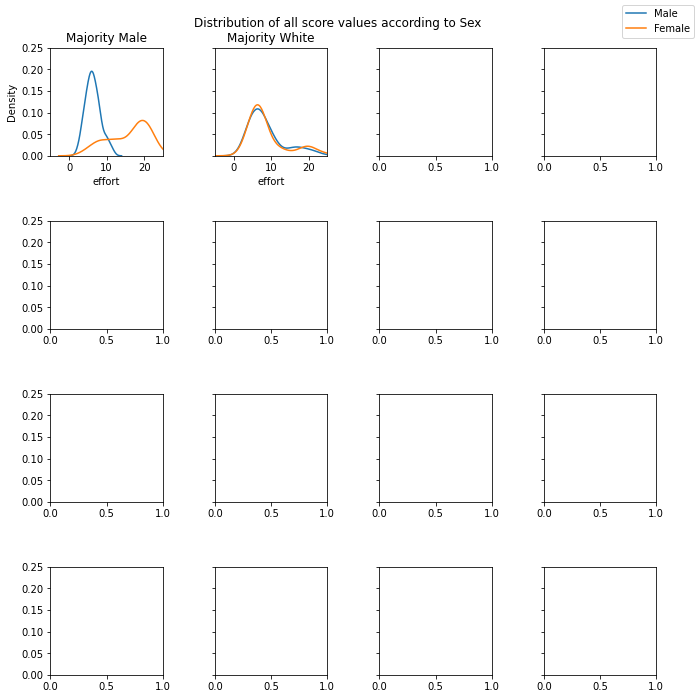

In [ ]:

## Without Sum of Score
sexes = ['Male', 'Female']
fig, axes_sex = plt.subplots(4, 4, figsize=(10, 10), sharey=True)
fig.suptitle('Distribution of all score values according to Sex')

for i,name in enumerate(algnames):
    
  for sex in sexes:
    ###(alg_total[name].effort != '-') & (alg_total[name].qualification > 0) & (alg_total[name].qualification < 30)   #### Condition for each category
    alg_total[name] = alg_total[name][(alg_total[name].effort != '-')]
    alg_total[name].effort=alg_total[name].effort.astype(float)
    #lm = sns.kdeplot(ax=axes_sex[int(np.floor(i/3)),i%3], data=alg_total[name].loc[(alg_total[name].sex==sex)],x="effort")
    lm = sns.kdeplot(ax=axes_sex[int(np.floor(i/3)),i%3], data=alg_total[name].loc[(alg_total[name].sex==sex)],x="effort")
    val_mean=alg_total[name].loc[(alg_total[name].sex==sex) & (alg_total[name].effort != '-')].effort.mean()
    print(name,sex,round(val_mean,1))

    lm.set(title=name)
    lm.set_xlim(left=-5, right=25)
    lm.set_ylim(bottom=0, top=0.25);

fig.tight_layout(pad=3.0)
fig.legend(labels=sexes)

In [ ]:
algnames

['Majority Male']

## Sex Results (With Qualification)

Majority Male Male 4.9
Majority Male Female 14.6
Majority White Male 8.1
Majority White Female 7.9


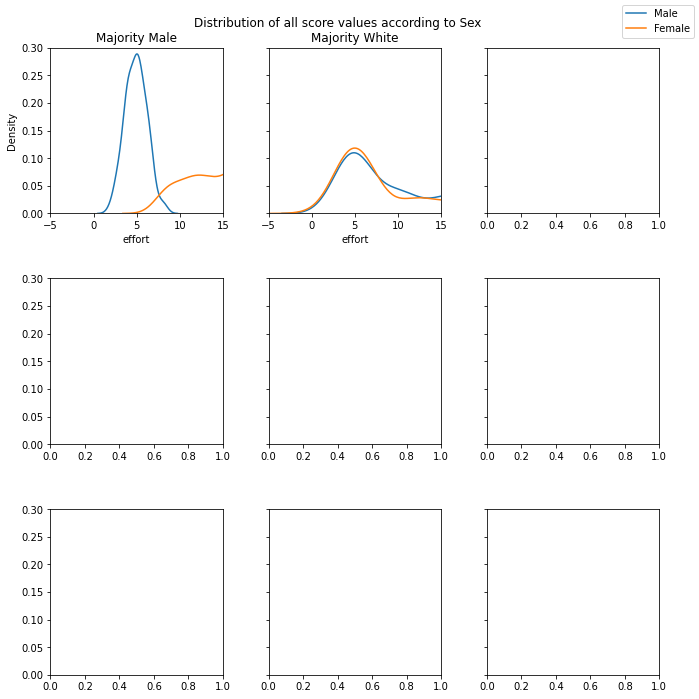

In [ ]:

## Without Sum of Score
sexes = ['Male', 'Female']
fig, axes_sex = plt.subplots(3, 3, figsize=(10, 10), sharey=True)
fig.suptitle('Distribution of all score values according to Sex')

for i,name in enumerate(algnames):
    
  for sex in sexes:
    ###(alg_total[name].effort != '-') & (alg_total[name].qualification > 0) & (alg_total[name].qualification < 30)   #### Condition for each category
    alg_total[name] = alg_total[name][(alg_total[name].effort != '-') ]
    alg_total[name].effort=alg_total[name].effort.astype(float)
    lm = sns.kdeplot(ax=axes_sex[int(np.floor(i/3)),i%3], data=alg_total[name].loc[(alg_total[name].sex==sex) & (alg_total[name].qualification > 12) & (alg_total[name].qualification < 24)],x="effort")
    val_mean=alg_total[name].loc[(alg_total[name].sex==sex) & (alg_total[name].qualification > 12) & (alg_total[name].qualification < 24)].effort.mean()
    print(name,sex,round(val_mean,1))

    lm.set(title=name)
    lm.set_xlim(left=-5, right=15)
    lm.set_ylim(bottom=0, top=0.3);

fig.tight_layout(pad=3.0)
fig.legend(labels=sexes)

## KL-Div

# Race Results (Without Qualification)

Random Forest White 6.5
Random Forest Asian-Pac-Islander 7.6
Random Forest Black 8.6
Random Forest Amer-Indian-Eskimo 9.7
Random Forest Other 9.8
Random Forest nan nan
Decision Tree White 5.2
Decision Tree Asian-Pac-Islander 4.9
Decision Tree Black 5.3
Decision Tree Amer-Indian-Eskimo 5.2
Decision Tree Other 4.7
Decision Tree nan nan
K-Nearest Neighbor White 6.1
K-Nearest Neighbor Asian-Pac-Islander 6.0
K-Nearest Neighbor Black 7.1
K-Nearest Neighbor Amer-Indian-Eskimo 7.2
K-Nearest Neighbor Other 6.4
K-Nearest Neighbor nan nan
Neural Net White 10.7
Neural Net Asian-Pac-Islander 11.3
Neural Net Black 12.8
Neural Net Amer-Indian-Eskimo 13.9
Neural Net Other 14.1
Neural Net nan nan
SVM White 8.9
SVM Asian-Pac-Islander 11.3
SVM Black 12.6
SVM Amer-Indian-Eskimo 10.4
SVM Other 13.9
SVM nan nan
Adaboost White 9.5
Adaboost Asian-Pac-Islander 10.3
Adaboost Black 11.2
Adaboost Amer-Indian-Eskimo 10.8
Adaboost Other 11.5
Adaboost nan nan
Random White 3.6
Random Asian-Pac-Islander 2.9
Random Bla

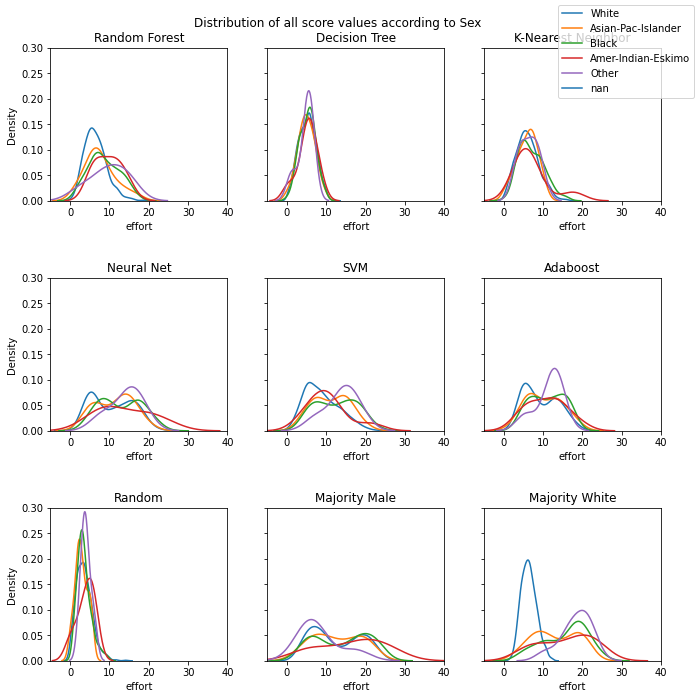

In [ ]:
races = alg_total['Random Forest']['race'].unique()

fig, axes_race = plt.subplots(3, 3, figsize=(10, 10), sharey=True)
fig.suptitle('Distribution of all score values according to Sex')

for i,name in enumerate(algnames):
    
  for race in races:
    alg_total[name] = alg_total[name][(alg_total[name].effort != '-') ]
    lm = sns.kdeplot(ax=axes_race[int(np.floor(i/3)),i%3], data=alg_total[name].loc[(alg_total[name].race==race)],x="effort")
    val_mean=alg_total[name].loc[(alg_total[name].race==race)].effort.mean()
    print(name,race,round(val_mean,1))

    lm.set(title=name)
    lm.set_xlim(left=-5, right=40)
    lm.set_ylim(bottom=0, top=0.3);

fig.tight_layout(pad=3.0)
fig.legend(labels=races)


# Race Results (With Qualification)

Majority Male White 11.7
Majority Male Asian-Pac-Islander 10.8
Majority Male Black 12.3
Majority Male nan nan
Majority Male Amer-Indian-Eskimo 4.3
Majority Male Other 3.0
Majority White White 4.9
Majority White Asian-Pac-Islander 14.1
Majority White Black 13.7
Majority White nan nan


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


Majority White Amer-Indian-Eskimo 12.9
Majority White Other 14.5


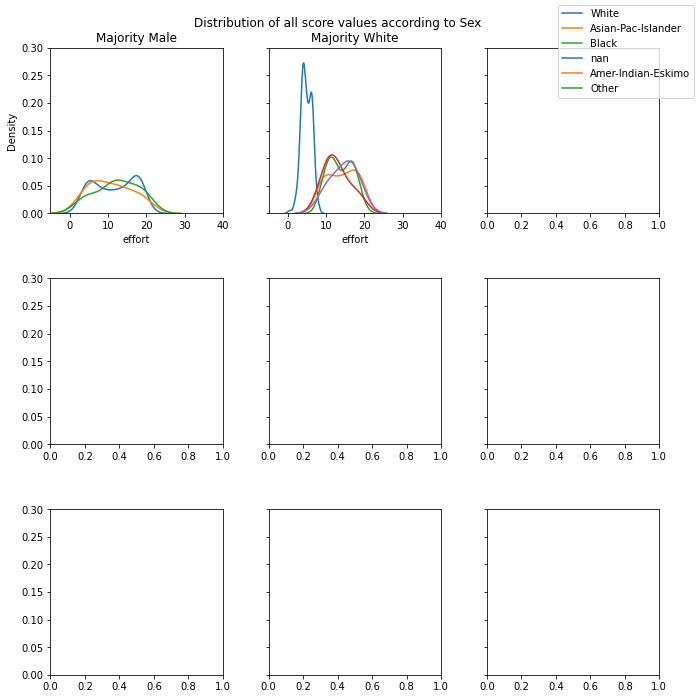

In [ ]:
races = alg_total['Majority Male']['race'].unique()

fig, axes_race = plt.subplots(3, 3, figsize=(10, 10), sharey=True)
fig.suptitle('Distribution of all score values according to Sex')

for i,name in enumerate(algnames):
  #val=[]
  for race in races:
    alg_total[name] = alg_total[name][(alg_total[name].effort != '-') ]
    lm = sns.kdeplot(ax=axes_race[int(np.floor(i/3)),i%3], data=alg_total[name].loc[(alg_total[name].race==race) & (alg_total[name].qualification > 12) & (alg_total[name].qualification < 24)],x="effort")
    val_mean=alg_total[name].loc[(alg_total[name].race==race) & (alg_total[name].qualification > 12) & (alg_total[name].qualification < 24)].effort.mean()
    print(name,race,round(val_mean,1))
    #val.append(round(val_mean,1))
    lm.set(title=name)
    lm.set_xlim(left=-5, right=40)
    lm.set_ylim(bottom=0, top=0.3);
  #print("std",name,np.std(np.array(val)))

fig.tight_layout(pad=3.0)
fig.legend(labels=races)